# Modeling

In [174]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [175]:
df_model = pd.read_csv('./Data/clean_data.csv', index_col=0)
df_model.head()

,amount_tsh,date_recorded,funder,gps_height,basin,region,local_government_area,population,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,source_type,waterpoint_type,status_group,construction_decade
0,6000.0,2011-03-14,Roman,1390,Lake Nyasa,Iringa,Ludewa,109,False,1999,gravity,user-group,annually,soft,enough,spring,communal standpipe,functional,1990s (1990-1999)
1,0.0,2013-03-06,Grumeti,1399,Lake Victoria,Mara,Serengeti,280,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2000s (2000-2009)
2,25.0,2013-02-25,Lottery Club,686,Pangani,Manyara,Simanjiro,250,True,2009,gravity,user-group,per bucket,soft,enough,dam,communal standpipe multiple,functional,2000s (2000-2009)
3,0.0,2013-01-28,Unicef,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,True,1986,submersible,user-group,never pay,soft,dry,borehole,communal standpipe multiple,non functional,1980s (1980-1989)
4,0.0,2011-07-13,Action In A,0,Lake Victoria,Kagera,Karagwe,0,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,Unknown


In [176]:
categorical_cols = ['region', 'extraction_type_class', 'management_group', 'funder',
                    'quantity', 'water_quality' , 'waterpoint_type', 'source_type', 'status_group' ]

In [177]:
numerical_cols = ['amount_tsh','gps_height', 'population']

In [178]:
df_model.drop(['date_recorded', 'construction_year', 'basin', 'local_government_area', 
                     'payment_type', 'permit', 'construction_decade'], axis=1, inplace=True)
#to be dropped before one hot encoding

In [179]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Encode the categorical columns in the DataFrame
for col in categorical_cols:
    df_model[col] = encoder.fit_transform(df_model[col])

# covert categorical columns to integer
for col in categorical_cols:
    df_model[col] = df_model[col].astype(int)

In [180]:
#from category_encoders import OneHotEncoder
#ohe = OneHotEncoder(cols = categorical_cols)

In [181]:
#df_model = ohe.fit_transform(df_model)

In [182]:
df_model.head()

,amount_tsh,funder,gps_height,region,population,extraction_type_class,management_group,water_quality,quantity,source_type,waterpoint_type,status_group
0,6000.0,1319,1390,3,109,0,4,6,1,6,1,0
1,0.0,457,1399,9,280,0,4,6,2,3,1,0
2,25.0,803,686,8,250,0,4,6,1,1,2,0
3,0.0,1681,263,12,58,5,4,6,0,0,2,1
4,0.0,18,0,4,0,0,1,6,3,3,1,0


In [183]:
# split the dataset
X = df_model.drop('status_group', axis=1)
y = df_model['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [184]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56344 entries, 0 to 59399
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56344 non-null  float64
 1   funder                 56344 non-null  int32  
 2   gps_height             56344 non-null  int64  
 3   region                 56344 non-null  int32  
 4   population             56344 non-null  int64  
 5   extraction_type_class  56344 non-null  int32  
 6   management_group       56344 non-null  int32  
 7   water_quality          56344 non-null  int32  
 8   quantity               56344 non-null  int32  
 9   source_type            56344 non-null  int32  
 10  waterpoint_type        56344 non-null  int32  
dtypes: float64(1), int32(8), int64(2)
memory usage: 3.4 MB


## Models

My data is now ready to be modeled. To begin, we will fit a dummy cllassifier model as my baseline model and analyze its performance indicators. Following that, I will fit several more classification models and evaluate their performance measures.

I will choose the two best-performing models from the four models based on accuracy. The remaining two models will subsequently be tuned with ensemble methods.


### 1. Dummy Classifier - Baseline model

> DummyClassifier makes predictions that ignore the input features. This classifier serves as a simple baseline to compare against other more complex classifiers.

- In terms of accuracy, the dummy classifier achieves an accuracy of 0.53, meaning that it correctly predicts the class for around 53% of the instances.

- Overall, these results indicate that the dummy classifier performs poorly in predicting class 1, as it never correctly identifies any instances of that class. It performs better in predicting class 0, achieving a reasonable precision and recall.

In [185]:
#Build a pipeline with a StandardScaler and a DummyClassifier
dummy_pipe = Pipeline([('scaler', StandardScaler()), 
                ('dummy', DummyClassifier(random_state=42))])
# fit the pipeline to the training set
dummy_pipe.fit(X_train, y_train)
# make predictions on the test set
y_pred_dummy = dummy_pipe.predict(X_test)
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dummy))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      7534
           1       0.00      0.00      0.00      6552

    accuracy                           0.53     14086
   macro avg       0.27      0.50      0.35     14086
weighted avg       0.29      0.53      0.37     14086



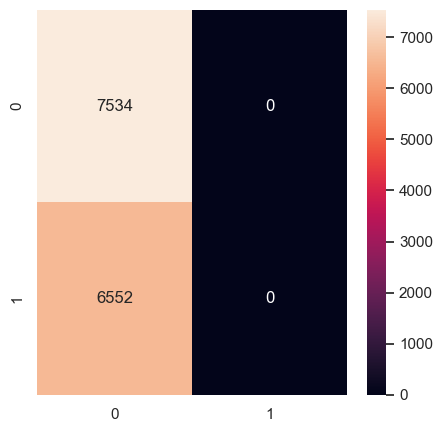

In [186]:
# Plot the confusion matrix without a color palette
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_dummy), annot=True, fmt='g')

# Show the plot
plt.show()

This is really low lets move to the next Classifier

### 2. Decision Tree Classifier

> Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class.

In [187]:
# Create a pipeline with a decision tree classifier as the estimator:
dt = Pipeline([('scaler', StandardScaler()),
                  ('tree', DecisionTreeClassifier(random_state=42))])
# fit the pipeline to the training set
dt.fit(X_train, y_train)
# make predictions on the test set
y_pred_dt = dt.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      7534
           1       0.77      0.72      0.74      6552

    accuracy                           0.77     14086
   macro avg       0.77      0.77      0.77     14086
weighted avg       0.77      0.77      0.77     14086



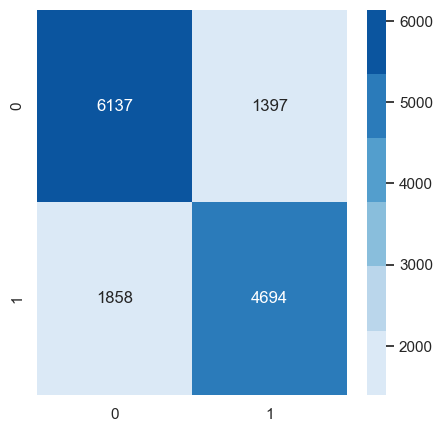

In [188]:
# Define a custom color palette
color_palette = sns.color_palette("Blues")
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='g', cmap=color_palette);

- The accuracy score represents the proportion of correctly predicted instances out of the total number of instances. In this case, the decision tree model achieved an accuracy of around 0.75, indicating that it predicted 75% of instances correctly.

### 3. Decision Tree with GridsearchCV

This combines a Decision Tree Classifier with GridSearchCV, which is a technique for hyperparameter tuning. GridSearchCV systematically tests different hyperparameter values for the decision tree to find the optimal combination that improves model performance.

In [189]:
dt = Pipeline([('scaler', StandardScaler()),
                  ('tree', DecisionTreeClassifier(random_state=42))])
# create a grid of parameters to test

param_grid = [{'tree__max_depth': [16, 18, 20],
              'tree__min_samples_split': [4, 6, 8],
              'tree__min_samples_leaf': [2, 3, 4],
              'tree__criterion': ['gini', 'entropy']}]

# create grid with estimators
gridsearch_dt = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid with the data    
gridsearch_dt.fit(X_train, y_train);

# Get the best parameters
best_params_dt = gridsearch_dt.best_params_

print("Best Parameters:", best_params_dt)
# Make predictions on the test data using the trained pipeline
y_pred_gridsearchdt = gridsearch_dt.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearchdt))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 20, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      7534
           1       0.80      0.69      0.74      6552

    accuracy                           0.78     14086
   macro avg       0.78      0.77      0.77     14086
weighted avg       0.78      0.78      0.78     14086



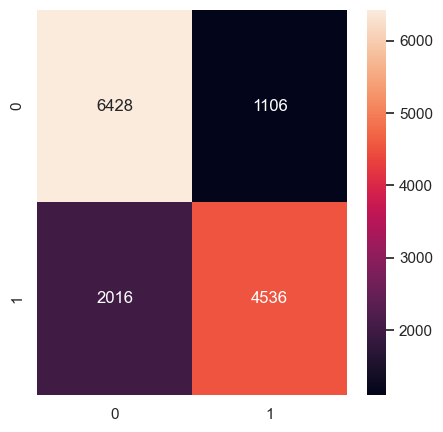

In [190]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gridsearchdt), annot=True, fmt='g');

The difference in accuracy you observed indicates that the model with GridSearchCV is performing better than the basic Decision Tree Classifier. Here’s what it means:

Decision Tree Classifier (0.77 accuracy): This is the performance of the basic decision tree model on your data.

Decision Tree with GridSearchCV (0.78 accuracy): This improved accuracy suggests that the GridSearchCV process found better hyperparameters for the decision tree model, leading to enhanced performance.

The 0.01(1%) increase in accuracy with GridSearchCV indicates that the hyperparameter tuning helped the model generalize better to the data, likely by optimizing settings like the tree depth, minimum samples per leaf, or other parameters. This improvement demonstrates the value of hyperparameter optimization in achieving better model performance.









As you can see the model has perfomed well since there are a lot of true positives and true negatives and there is a low number of false positives and negatives, meaning he model was able to predict accurately to some extent.

### 4. Support Vector Machine (SVM) classifier

> A Support Vector Machine (SVM) classifier is a powerful supervised machine learning algorithm used for both classification and regression tasks. It is particularly effective in handling high-dimensional feature spaces and datasets with clear separation between classes

In [191]:
# Create a pipeline with an SVM classifier as the estimator
svm_clf  = Pipeline([('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))
])

# Fit the pipeline on the training data
svm_clf.fit(X_train, y_train)

# Make predictions on the test data using the trained pipeline
y_pred_svm = svm_clf.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      7534
           1       0.85      0.51      0.64      6552

    accuracy                           0.73     14086
   macro avg       0.77      0.72      0.71     14086
weighted avg       0.76      0.73      0.72     14086



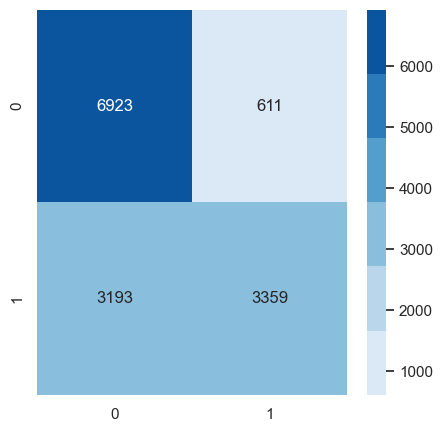

In [192]:
# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='g', cmap=color_palette);

###  5. K-Nearest Neighbors

> K-Nearest Neighbors (KNN) is a simple yet effective machine learning algorithm used for both classification and regression tasks. It is a non-parametric algorithm that makes predictions based on the similarity of data points in the feature space.

In [193]:
knn_clf = Pipeline([('scaler', StandardScaler()),
                     ('knn_clf', KNeighborsClassifier())
])

# Fit the pipeline to the training data
knn_clf.fit(X_train, y_train)

# make predictions on test data
y_pred_knn = knn_clf.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      7534
           1       0.77      0.72      0.74      6552

    accuracy                           0.77     14086
   macro avg       0.77      0.77      0.77     14086
weighted avg       0.77      0.77      0.77     14086



In [194]:
len(y_test), len(y_pred_knn)

(14086, 14086)

In [195]:
y_pred_knn = y_pred_knn[:len(y_test)]

- The accuracy of the model is 0.76, indicating that it correctly classifies 76% of the instances.

### 6. K-Nearest Neighbors with grid search

In [196]:
# Define the parameter grid for GridSearchCV
param_grid_knn = {
    'knn_clf__n_neighbors': [3, 5, 7],
    'knn_clf__weights': ['uniform', 'distance'],
    'knn_clf__p': [1, 2]
}

# Create the GridSearchCV object
gridsearch_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid_knn, cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV on the training data
gridsearch_knn.fit(X_train, y_train)

# Get the best parameters
best_params_knn = gridsearch_knn.best_params_

print("Best Parameters:", best_params_knn)

# Make predictions on the test data using the trained pipeline
y_pred_gridsearchknn = gridsearch_knn.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gridsearchknn))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'knn_clf__n_neighbors': 7, 'knn_clf__p': 1, 'knn_clf__weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      7534
           1       0.78      0.73      0.76      6552

    accuracy                           0.78     14086
   macro avg       0.78      0.78      0.78     14086
weighted avg       0.78      0.78      0.78     14086



Best Parameters: The best parameters found during the grid search are:

- Number of neighbors (knn_clf__n_neighbors): 7
- Distance metric power parameter (knn_clf__p): 1
- Weighting scheme (knn_clf__weights): 'distance'


- Accuracy: The accuracy of the model is 0.77, indicating that it correctly classifies 77% of the instances.

# Logistic regression

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create a pipeline with a StandardScaler and a LogisticRegression classifier
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=42))
])

#Fit the pipeline to the training set
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      7534
           1       0.57      0.50      0.53      6552

    accuracy                           0.59     14086
   macro avg       0.59      0.58      0.58     14086
weighted avg       0.59      0.59      0.59     14086



Thats really low for a classifier. Logistic regression is suppossed to do the below;  

Logistic regression is a statistical model commonly used for binary classification tasks, where the goal is to predict one of two possible classes (e.g., 0 or 1, "yes" or "no").  

Logistic regression outputs probability scores for each class.   

 probabilities represent the likelihood that a given input belongs to a particular class. For a binary classification problem, logistic regression calculates the probability that an observation belongs to the positive class (typically labeled as 1).

Lets try to fing different ways to improve this model. Using this classifier, Simple models like Logistic Regression is easier to interpret compared to others.

In [198]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load your data into a DataFrame
df = pd.read_csv('./Data/clean_data.csv') 

# Split your data into features and target variable
X = df.drop('status_group', axis=1)  # Replace 'status_group' with the name of your target variable
y = df['status_group']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the preprocessing for numerical and categorical columns
numerical_cols = ['amount_tsh', 'gps_height', 'population']
categorical_cols = ['region', 'extraction_type_class', 'management_group', 'funder',
                    'quantity', 'water_quality', 'waterpoint_type', 'source_type']

# Define preprocessing for numerical data (imputation + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data (imputation + one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                precision    recall  f1-score   support

    functional       0.73      0.85      0.78      6039
non functional       0.79      0.63      0.70      5230

      accuracy                           0.75     11269
     macro avg       0.76      0.74      0.74     11269
  weighted avg       0.75      0.75      0.74     11269



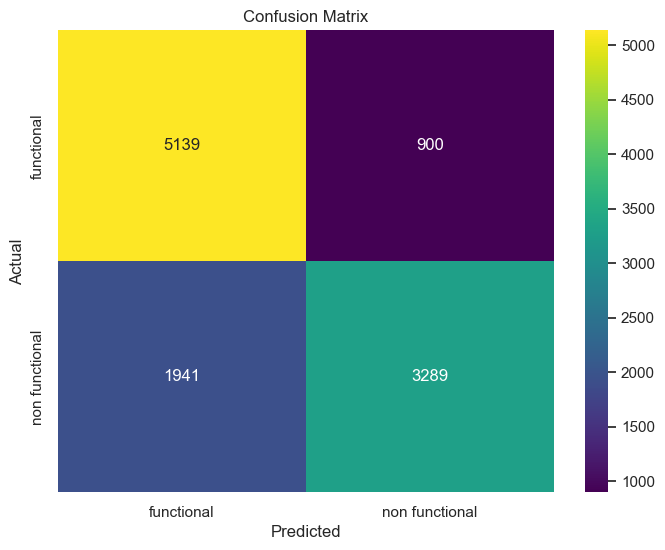

In [199]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a colored heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=logreg_pipeline.classes_, yticklabels=logreg_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Engineering

In [200]:
df.isnull().sum()

Unnamed: 0                  0
amount_tsh                  0
date_recorded               0
funder                   1219
gps_height                  0
basin                       0
region                      0
local_government_area       0
population                  0
permit                      0
construction_year           0
extraction_type_class       0
management_group            0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
status_group                0
construction_decade         0
dtype: int64

In [201]:
len(df['amount_tsh']), len(df['gps_height'])


(56344, 56344)

In [202]:
print(df[['amount_tsh', 'gps_height']].head())


   amount_tsh  gps_height
0      6000.0        1390
1         0.0        1399
2        25.0         686
3         0.0         263
4         0.0           0


Create Interaction Features

Interaction features capture relationships between variables that might be missed if you only look at individual features. For instance, combining amount_tsh and gps_height could reveal insights into the relationship between these features.

In [203]:
# Create an interaction feature
df['amount_tsh_gps_height'] = df['amount_tsh'] * df['gps_height']


Polynomial Features


Polynomial features are used to capture non-linear relationships. For numerical features, you can create polynomial terms (e.g., squared or cubic terms).

In [204]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize PolynomialFeatures with degree 2 (squared terms)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the numerical features
X_numerical_poly = poly.fit_transform(df[numerical_cols])

# Create a DataFrame from the transformed features
df_numerical_poly = pd.DataFrame(X_numerical_poly, columns=poly.get_feature_names_out(numerical_cols))

# Concatenate the original DataFrame with the new polynomial features
df = pd.concat([df, df_numerical_poly], axis=1)


Binning

Binning involves converting continuous variables into categorical bins, which can help in managing outliers and capturing non-linear relationships

In [205]:
# Check the structure of 'gps_height'
print(df['gps_height'].head())  # View the first few entries
print(df['gps_height'].apply(lambda x: type(x)).unique())  # Check the data types within the column


   gps_height  gps_height
0        1390      1390.0
1        1399      1399.0
2         686       686.0
3         263       263.0
4           0         0.0
[<class 'pandas.core.series.Series'>]


In [206]:
# Check for duplicate indices
print(df.index[df.index.duplicated()].tolist())

# Check for duplicate columns
print(df.columns[df.columns.duplicated()].tolist())


[]
['amount_tsh', 'gps_height', 'population']


In [207]:
# Reset index to remove duplicates
df = df.reset_index(drop=True)


In [208]:
# Remove duplicate columns, keeping the first occurrence
df = df.loc[:, ~df.columns.duplicated()]


In [209]:
# Ensure 'gps_height' is numeric
df['gps_height'] = pd.to_numeric(df['gps_height'], errors='coerce')

# Define bins and labels
bins = [0, 500, 1000, 1500, 2000, 2500, 3000]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme']

# Apply binning
df['gps_height_binned'] = pd.cut(df['gps_height'], bins=bins, labels=labels)

# Verify the result
print(df[['gps_height', 'gps_height_binned']].head())


   gps_height gps_height_binned
0        1390            Medium
1        1399            Medium
2         686               Low
3         263          Very Low
4           0               NaN


In [210]:
# Check if 'gps_height' contains any non-numeric values
print(df['gps_height'].dtype)

# Verify 'gps_height_binned' values
print(df['gps_height_binned'].value_counts())


int64
gps_height_binned
Medium       11913
Very Low      9682
High          7629
Low           5085
Very High     1177
Extreme         30
Name: count, dtype: int64


In [211]:
# Example of a domain-specific feature
major_funders = ['Funder1', 'Funder2', 'Funder3']  # List of known major funders

# Create a binary feature indicating if the funder is a major funder
df['major_funder'] = df['funder'].apply(lambda x: 1 if x in major_funders else 0)


1. Amount TSH
Log Transformation:

In [212]:
df['log_amount_tsh'] = np.log1p(df['amount_tsh'])


In [213]:
bins_amount_tsh = [0, 1000, 5000, 10000, 50000, 100000]
labels_amount_tsh = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['amount_tsh_binned'] = pd.cut(df['amount_tsh'], bins=bins_amount_tsh, labels=labels_amount_tsh)


In [214]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['amount_tsh_standardized'] = scaler.fit_transform(df[['amount_tsh']])


GPS Height
Log Transformation:

In [215]:
df['log_gps_height'] = np.log1p(df['gps_height'])


In [216]:
bins_gps_height = [0, 500, 1000, 1500, 2000, 2500, 3000]
labels_gps_height = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme']
df['gps_height_binned'] = pd.cut(df['gps_height'], bins=bins_gps_height, labels=labels_gps_height)


In [217]:
scaler = StandardScaler()
df['gps_height_standardized'] = scaler.fit_transform(df[['gps_height']])


3. Population Log Transformation

In [218]:
df['log_population'] = np.log1p(df['population'])


In [219]:
bins_population = [0, 500, 1000, 5000, 10000, 50000]
labels_population = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
df['population_binned'] = pd.cut(df['population'], bins=bins_population, labels=labels_population)


In [220]:
scaler = StandardScaler()
df['population_standardized'] = scaler.fit_transform(df[['population']])


Interaction Features
1. Amount TSH and GPS Height Interaction

In [221]:
df['amount_tsh_gps_height'] = df['amount_tsh'] * df['gps_height']


2.Amount TSH and Population Interaction:

In [222]:
df['amount_tsh_population'] = df['amount_tsh'] * df['population']


3.GPS Height and Population Interaction:

In [223]:
df['gps_height_population'] = df['gps_height'] * df['population']


In [224]:
# again view the summary of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56344 entries, 0 to 56343
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               56344 non-null  int64   
 1   amount_tsh               56344 non-null  float64 
 2   date_recorded            56344 non-null  object  
 3   funder                   55125 non-null  object  
 4   gps_height               56344 non-null  int64   
 5   basin                    56344 non-null  object  
 6   region                   56344 non-null  object  
 7   local_government_area    56344 non-null  object  
 8   population               56344 non-null  int64   
 9   permit                   56344 non-null  bool    
 10  construction_year        56344 non-null  int64   
 11  extraction_type_class    56344 non-null  object  
 12  management_group         56344 non-null  object  
 13  payment_type             56344 non-null  object  
 14  water_

In [225]:
print(df.head())  # Check the first few rows of the original DataFrame
print(df.shape)   # Check the shape of the DataFrame (rows, columns)


   Unnamed: 0  amount_tsh date_recorded        funder  gps_height  \
0           0      6000.0    2011-03-14         Roman        1390   
1           1         0.0    2013-03-06       Grumeti        1399   
2           2        25.0    2013-02-25  Lottery Club         686   
3           3         0.0    2013-01-28        Unicef         263   
4           4         0.0    2011-07-13   Action In A           0   

                     basin   region local_government_area  population  permit  \
0               Lake Nyasa   Iringa                Ludewa         109   False   
1            Lake Victoria     Mara             Serengeti         280    True   
2                  Pangani  Manyara             Simanjiro         250    True   
3  Ruvuma / Southern Coast   Mtwara              Nanyumbu          58    True   
4            Lake Victoria   Kagera               Karagwe           0    True   

   ...  log_amount_tsh amount_tsh_binned amount_tsh_standardized  \
0  ...        8.699681        

In [226]:
# Fill NaN values in numeric columns with the mean of those columns
#df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)


In [227]:
# Fill NaN in numeric columns with the mean
df_numeric = df.select_dtypes(include=[np.number])
df[df_numeric.columns] = df_numeric.fillna(df_numeric.mean())

# Fill NaN in non-numeric columns with a different strategy (e.g., mode)
df_non_numeric = df.select_dtypes(exclude=[np.number])
df[df_non_numeric.columns] = df_non_numeric.fillna(df_non_numeric.mode().iloc[0])


In [228]:
duplicates = df.duplicated()
print(duplicates)


0        False
1        False
2        False
3        False
4        False
         ...  
56339    False
56340    False
56341    False
56342    False
56343    False
Length: 56344, dtype: bool


In [229]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)


Empty DataFrame
Columns: [Unnamed: 0, amount_tsh, date_recorded, funder, gps_height, basin, region, local_government_area, population, permit, construction_year, extraction_type_class, management_group, payment_type, water_quality, quantity, source_type, waterpoint_type, status_group, construction_decade, amount_tsh_gps_height, amount_tsh^2, amount_tsh gps_height, amount_tsh population, gps_height^2, gps_height population, population^2, gps_height_binned, major_funder, log_amount_tsh, amount_tsh_binned, amount_tsh_standardized, log_gps_height, gps_height_standardized, log_population, population_binned, population_standardized, amount_tsh_population, gps_height_population]
Index: []

[0 rows x 39 columns]


The output indicates that there are no duplicate rows in your DataFrame (df). This means that every row is unique across all columns, which is why duplicate_rows returns an empty DataFrame.

In [230]:
# Identify near-duplicate rows based on specific columns
near_duplicates = df[df.duplicated(subset=['amount_tsh', 'gps_height', 'population'])]

# Display the near-duplicate rows
print(near_duplicates)


       Unnamed: 0  amount_tsh date_recorded                  funder  \
6               6         0.0    2012-10-01                    Dwsp   
7               7         0.0    2012-10-09                   Rwssp   
8               8         0.0    2012-11-03                Wateraid   
9               9         0.0    2011-08-03             Isingiro Ho   
12             12         0.0    2012-10-14            World Vision   
...           ...         ...           ...                     ...   
56328       59384         0.0    2011-07-10                 Concern   
56336       59392         0.0    2011-04-15  Government Of Tanzania   
56337       59393         0.0    2012-10-27                 Private   
56341       59397         0.0    2011-04-11  Government Of Tanzania   
56342       59398         0.0    2011-03-08                   Malec   

       gps_height            basin     region local_government_area  \
6               0         Internal  Shinyanga       Shinyanga Rural   
7    

In [231]:
#df_cleaned = df.drop_duplicates(subset=['amount_tsh', 'gps_height', 'population'], keep='first')


In [232]:
# Drop near-duplicate rows based on specific columns and keep the first occurrence
#df_cleaned = df.drop_duplicates(subset=['amount_tsh', 'gps_height', 'population'], keep='first')

# Display the cleaned DataFrame
#print(df_cleaned.head())


In [233]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [234]:
print(df['amount_tsh'].isnull().sum())  # Check for NaN values
print(df['amount_tsh'].describe())  # Summary statistics of the column


0
count    56344.000000
mean         0.001289
std          0.010599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000120
max          1.000000
Name: amount_tsh, dtype: float64


In [235]:
print(df['amount_tsh'].unique())


[2.400e-02 0.000e+00 1.000e-04 8.000e-05 8.000e-04 2.000e-03 2.000e-04
 1.600e-02 6.000e-03 2.400e-05 1.000e-03 4.000e-05 4.000e-03 4.000e-04
 1.200e-04 8.000e-03 1.600e-03 4.800e-03 1.600e-04 1.200e-03 1.000e-01
 3.000e-03 2.000e-02 2.400e-03 2.880e-02 9.600e-03 2.000e-05 1.440e-02
 1.800e-03 1.600e-01 4.800e-02 1.200e-02 2.800e-05 8.000e-02 1.120e-02
 8.800e-03 2.800e-04 2.200e-02 4.000e-02 1.000e-02 2.600e-02 2.200e-03
 1.320e-04 3.200e-02 1.880e-02 2.800e-02 5.600e-02 5.200e-03 4.000e-01
 2.800e-03 4.000e-06 2.400e-04 1.400e-03 8.000e-07 1.400e-04 1.224e-03
 3.400e-02 4.680e-01 1.400e-02 2.080e-03 6.000e-05 2.520e-02 6.000e-04
 5.520e-01 1.800e-02 5.200e-02 1.800e-01 8.000e-06 6.000e-02 4.400e-02
 2.000e-01 3.000e-02 6.520e-02 3.200e-03 6.400e-02 1.200e-01 2.120e-04
 2.160e-02 2.800e-01 1.000e+00 8.000e-01 1.040e-01 7.200e-02 1.040e-04
 2.360e-03 3.600e-03 3.600e-05 5.600e-03 6.800e-01 8.800e-04 1.520e-01
 1.000e-06 4.800e-05 2.400e-01 2.360e-04]


Classification Report:
                precision    recall  f1-score   support

    functional       0.70      0.86      0.77      6039
non functional       0.78      0.59      0.67      5230

      accuracy                           0.73     11269
     macro avg       0.74      0.72      0.72     11269
  weighted avg       0.74      0.73      0.72     11269



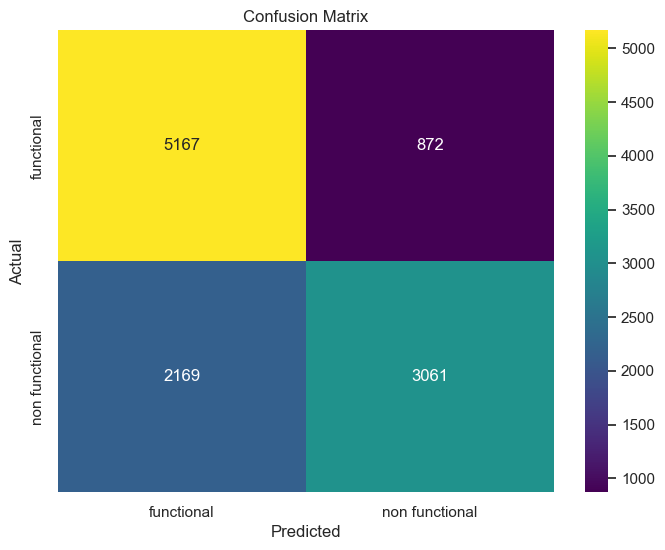

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# Load your data into a DataFrame
df = pd.read_csv('./Data/clean_data.csv')

# Split your data into features and target variable
X = df.drop('status_group', axis=1)  # Replace 'status_group' with the name of your target variable
y = df['status_group']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom transformer to create domain-specific features
class DomainSpecificFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create interaction feature
        X['amount_tsh_gps_height'] = X['amount_tsh'] * X['gps_height']
        
        # Flagging unusually high values for amount_tsh
        X['high_amount_tsh'] = (X['amount_tsh'] > 1000).astype(int)
        
        return X[['amount_tsh_gps_height', 'high_amount_tsh']]

# Define preprocessing for numerical data (imputation + polynomial features + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Adding polynomial features
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data (imputation + one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data with domain-specific features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('domain', DomainSpecificFeatures(), numerical_cols)
    ])

# Create the logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_pipeline.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a colored heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=logreg_pipeline.classes_, yticklabels=logreg_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The classification report evaluates the performance of a model distinguishing between "functional" and "non functional" classes. Here's a summary:

Functional Class: The model has a good recall (0.86) and a decent precision (0.70), meaning it correctly identifies most functional samples but has some false positives.

Non-functional Class: The model has higher precision (0.78) but lower recall (0.59), indicating it correctly identifies non-functional samples when predicted but misses many actual non-functional samples.

Overall Accuracy: The model correctly classifies 73% of all samples.

Balanced Performance: The weighted and macro averages show that the model has a slightly better overall precision and recall for the "functional" class, but struggles more with identifying "non functional" cases.

The drop in classifier performance from 0.78 to 0.73 was likely due to:

Feature Engineering: Removing or altering features may have removed important information or introduced noise.
Model Adjustments: Changes in model complexity or hyperparameters could have led to reduced effectiveness.
In essence, modifications during feature engineering and model tuning likely caused the decline in performance.

In [237]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for logistic regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],       # Norm used in penalization
    'classifier__solver': ['liblinear']        # Solver algorithm
}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Best parameters found:  {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score:  0.7469107043815864


In conclusion, the findings suggest several important considerations for stakeholders when planning the construction and maintenance of wells in Tanzania. The Dodoma region has a higher number of non-functional wells compared to functional ones, indicating a need for careful assessment and investigation into the causes and potential solutions before building new wells. Data analysis shows that wells with operating permits tend to remain functional longer than those without permits, highlighting the importance of regulatory compliance. Furthermore, wells that are not associated with any payment plan often become inoperable due to public misuse; therefore, implementing a reasonable payment plan could help maintain well functionality. To ensure sustainable water access, stakeholders should focus on regions with higher failure rates, verify that all wells have the necessary permits, and consider the establishment of payment plans to enhance the viability of the wells.

1.Regular Maintenance and Repairs: To ensure continuous access to water, it is crucial to implement a robust maintenance schedule for functional wells and promptly repair those classified as needing repair or non-functional. Predictive maintenance, using insights from data analysis, can help optimize resource allocation and minimize pump downtime.

2.Improved Data Collection and Management: Enhance data collection practices to include more accurate and up-to-date information on well status, location, and usage. This will help in better decision-making and resource distribution for maintenance and repairs.

3.Community Involvement and Training: Engage local communities in the maintenance and management of water points. Training local users and managers can lead to quicker identification and reporting of issues, promoting sustainability and ownership.

4.Use of Advanced Machine Learning Models: The project should consider using advanced machine learning models like Random Forest or Gradient Boosting for better predictive accuracy regarding well functionality. Hyperparameter tuning, as done with GridSearchCV in the study, can further improve model performance.